In [1]:
import logging
import os
import sys
os.environ['GLEAMS_HOME'] = os.path.join(os.environ['HOME'],
                                         'Projects/gleams')
# Make sure all code is in the PATH.
sys.path.append(
    os.path.normpath(os.path.join(os.environ['GLEAMS_HOME'], 'src')))

In [2]:
import collections
import math
from typing import List

import joblib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import pyteomics
import seaborn as sns

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from gleams.dag import dag

from gleams import config
from gleams.ms_io import ms_io
from gleams.cluster import cluster

Using TensorFlow backend.
RDKit WARNING: [16:54:57] Enabling RDKit 2019.09.1 jupyter extensions
Loading faiss with AVX2 support.


In [5]:
# Plot styling.
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # Single-column figure.

In [6]:
logging.basicConfig(format='{asctime} '
                           '{module}.{funcName} : {message}',
                    style='{', level=logging.DEBUG, force=True)
logger = logging.getLogger('gleams')

## Clustering

Cluster the spectra (using the previously determined optimal clustering hyperparameters).

In [7]:
config.eps = 0.02
config.min_samples = 2
os.remove(os.path.join(os.environ['GLEAMS_HOME'], 'data', 'ann',
                       f'clusters_{config.massivekb_task_id}.npy'))
cluster.cluster(os.path.join(os.environ['GLEAMS_HOME'], 'data', 'ann',
                             f'dist_{config.massivekb_task_id}.npz'))

[2019-12-10 16:55:01,641] {cluster.py:269} INFO - DBSCAN clustering (eps=0.02, min_samples=2) of precomputed pairwise distance matrix /home/wout/Projects/gleams/data/ann/dist_100.npz
[2019-12-10 16:55:06,158] {warnings.py:110} WARNING - /home/wout/.conda/envs/gleams/lib/python3.7/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)



In [8]:
clusters = pd.merge(
    pd.read_parquet(
        os.path.join(os.environ['GLEAMS_HOME'], 'data', 'embed',
                     f'embed_{config.massivekb_task_id}.parquet')),
    pd.read_parquet(
        os.path.join(os.environ['GLEAMS_HOME'], 'data', 'metadata',
                     f'metadata_{config.massivekb_task_id}.parquet')),
    'left', ['dataset', 'filename', 'scan'])
# Don't disambiguate between I/L.
clusters['sequence'] = clusters['sequence'].str.replace('I', 'L')
clusters['cluster'] = np.load(os.path.join(
    os.environ['GLEAMS_HOME'], 'data', 'ann',
    f'clusters_{config.massivekb_task_id}.npy'))

In [9]:
num_id_massive = len(clusters['sequence'].dropna())
print(f'Number of initial spectrum identifications: {num_id_massive:,} '
      f'({(num_id_massive / len(clusters)):.2%})')

Number of initial spectrum identifications: 572,961 (11.92%)


## Spectrum export

Export the unidentified spectra that are part of valid clusters to MGF files used for reidentification. Spectra belonging to the noise cluster are not exported.

We hypothesize the clustered spectra correspond to higher quality spectra that are repeatedly measured.

In [10]:
reident_peak_dir = os.path.join(os.environ['GLEAMS_HOME'], 'data', 'ann',
                                'peak')
os.makedirs(reident_peak_dir, exist_ok=True)
existing_peak_files = set([os.path.splitext(filename)[0]
                           for filename in os.listdir(reident_peak_dir)
                           if filename.endswith('.mgf')])

In [11]:
clusters_non_ident = (clusters[clusters['cluster'] != -1].groupby('cluster')
                      ['sequence'].apply(lambda sequences:
                                         all(pd.isnull(sequences))))
clusters_non_ident = clusters_non_ident[clusters_non_ident].index
dataset_filename_scans = (clusters[clusters['cluster']
                                   .isin(clusters_non_ident)]
                          .groupby(['dataset', 'filename'])
                          ['scan'].apply(list)
                          .reset_index())
dataset_filename_scans = dataset_filename_scans[
    ~dataset_filename_scans['dataset'].isin(existing_peak_files)]

In [12]:
num_unid_export = dataset_filename_scans['scan'].apply(len).sum()
print(f'Number of clustered, unidentified spectra: {num_unid_export:,} '
      f'({(num_unid_export / len(clusters)):.2%})')

Number of clustered, unidentified spectra: 666,950 (13.87%)


In [13]:
def get_spectra_from_file(dataset: str, filename: str, scans: List[int]):
    logger.debug('Process file %s/%s', dataset, filename)
    return list(ms_io.get_spectra(os.path.join(
        os.environ['GLEAMS_HOME'], 'data', 'peak', dataset, filename)))

In [ ]:
logger.info('Read and export clustered, unidentified spectra to MGF files '
            'in directory %s', reident_peak_dir)
# TODO: Parallelize within each dataset instead to reduce memory requirements.
for spectra in joblib.Parallel(n_jobs=-1, backend='multiprocessing')(
        joblib.delayed(get_spectra_from_file)(dataset, filename, scans)
        for dataset, filename, scans in zip(
            dataset_filename_scans['dataset'],
            dataset_filename_scans['filename'],
            dataset_filename_scans['scan'])):
    spectra_dicts = [{'m/z array': spectrum.mz,
                      'intensity array': spectrum.intensity,
                      'params': {
                          'TITLE': f'mzspec:{dataset}:' \
                              f'{os.path.splitext(filename)[0]}:' \
                              f'scan:{spectrum.identifier}',
                          'RTINSECONDS': spectrum.retention_time,
                          'PEPMASS': spectrum.precursor_mz,
                          'CHARGE': f'{spectrum.precursor_charge}+'}}
                     for spectrum in spectra]
    with open(os.path.join(reident_peak_dir, f'{dataset}.mgf'), 'w') as f_out:
        pyteomics.mgf.write(spectra_dicts, f_out)

## Incorporate ANN-SoLo identifications

Include the identifications from ANN-SoLo processing of the previously exported unidentified spectra.

In [15]:
def read_mztab_psms(filename: str) -> pd.DataFrame:
    """
    Read PSMs from the given mzTab file.
    
    Parameters
    ----------
    filename: str
        The mzTab file name from which to read the PSMs.
    
    Returns
    -------
    pd.DataFrame
        A data frame containing the PSM information from the mzTab file.
    """
    # Skip the header lines.
    skiplines = 0
    with open(filename) as f_in:
        line = next(f_in)
        while line.split('\t', 1)[0] != 'PSH':
            line = next(f_in)
            skiplines += 1

    psms = pd.read_csv(filename, sep='\t', header=skiplines,
                       index_col='PSM_ID')
    psms.drop('PSH', 1, inplace=True)

    psms['opt_ms_run[1]_cv_MS:1002217_decoy_peptide'] =\
        psms['opt_ms_run[1]_cv_MS:1002217_decoy_peptide'].astype(bool)

    psms.df_name = os.path.splitext(os.path.basename(filename))[0]

    return psms

In [16]:
reident_id_dir = os.path.join(os.environ['GLEAMS_HOME'], 'data', 'ann', 'id')
psms = pd.concat([read_mztab_psms(os.path.join(reident_id_dir, filename))
                  for filename in os.listdir(reident_id_dir)
                  if os.path.splitext(filename)[1] == '.mztab'])
psms['sequence'] = psms['sequence'].str.replace('I', 'L')

In [17]:
num_id_ann_solo = len(psms)
print(f'Number of ANN-SoLo spectrum identifications: {num_id_ann_solo:,} '
      f'({(num_id_ann_solo / len(clusters)):.2%}; '
      f'{(num_id_ann_solo / num_unid_export):.2%} of previously unidentified '
      f'spectra)')

Number of ANN-SoLo spectrum identifications: 467,263 (9.72%; 70.06% of previously unidentified spectra)


In [18]:
clusters = clusters.set_index(
    'mzspec:' + clusters['dataset'] + ':' +
    clusters['filename'].str.rsplit('.', 1, True)[0] + ':scan:' +
    clusters['scan'].astype(str))

In [19]:
clusters.loc[psms.index, 'sequence'] = psms['sequence']
clusters['ann_solo'] = False
clusters.loc[psms.index, 'ann_solo'] = True

### Mass difference histogram

In [20]:
def get_mass_groups(psms, tol_mass, tol_mode, min_group_size=None):
    psms_remaining = psms.sort_values('search_engine_score[1]',
                                      ascending=False)
    psms_remaining['mass_diff'] = ((psms_remaining['exp_mass_to_charge'] -
                                    psms_remaining['calc_mass_to_charge']) *
                                   psms_remaining['charge'])

    # Start with the highest ranked SSM.
    mass_groups = []
    while psms_remaining.size > 0:
        # Find all remaining PSMs within the mass difference window.
        mass_diff = psms_remaining['mass_diff'].iat[0]
        if (tol_mass is None or tol_mode not in ('Da', 'ppm') or
                min_group_size is None):
            mask = np.full(len(psms_remaining), True, dtype=bool)
        elif tol_mode == 'Da':
            mask = (np.fabs(psms_remaining['mass_diff'] - mass_diff) <=
                    tol_mass)
        elif tol_mode == 'ppm':
            mask = (np.fabs(psms_remaining['mass_diff'] - mass_diffs) /
                    psms_remaining['exp_mass_to_charge'] * 10 ** 6
                    <= tol_mass)
        mass_groups.append(psms_remaining[mask])
        # Exclude the selected PSMs from further selections.
        psms_remaining = psms_remaining[~mask]

    mass_group_stats = []
    for mass_group in mass_groups:
        mass_group_stats.append((mass_group['mass_diff'].median(),
                                 mass_group['mass_diff'].mean(),
                                 len(mass_group)))
    mass_group_stats = pd.DataFrame.from_records(
        mass_group_stats, columns=['mass_diff_median', 'mass_diff_mean',
                                   'num_psms'])
    return mass_group_stats

In [21]:
tol_mass, tol_mode, min_group_size = 0.1, 'Da', 20
mass_groups = get_mass_groups(psms, tol_mass, tol_mode, min_group_size)

In [22]:
mass_groups.sort_values('num_psms', ascending=False).head(20)

,mass_diff_median,mass_diff_mean,num_psms
0,0.000712,0.000874,276534
31,15.995084,15.998251,11736
4,1.002557,1.002552,9371
55,8.015573,8.016793,6142
1,2.005900,2.001367,3976
83,10.009917,10.012433,3435
78,-18.010084,-18.007321,3153
2,17.022786,17.013212,3123
34,-17.024974,-17.021685,2917
27,-0.987162,-0.996658,2697


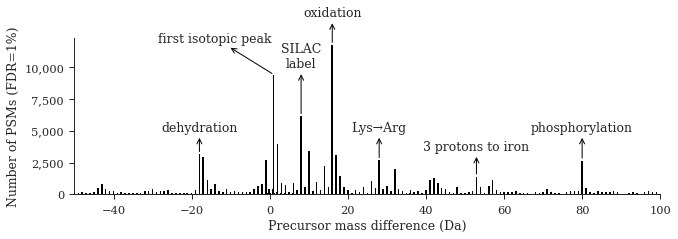

In [23]:
width = 7
height = width / 1.618
fig, ax = plt.subplots(figsize=(width * 1.5, height / 1.5))

# Exclude unmodified PSMs.
mask = mass_groups['mass_diff_median'].abs() > tol_mass
ax.bar(mass_groups[mask]['mass_diff_median'], mass_groups[mask]['num_psms'],
       width=0.4, color='black')

# Annotate the most frequent modifications.
modifications = [('oxidation', 0, 14000),
                 ('first isotopic peak', -15, 12000),
                 ('SILAC\nlabel', 0, 10000),
                 (None, None, None),
                 (None, None, None),
                 ('dehydration', 0, 5000),
                 (None, None, None),
                 (None, None, None),
                 (None, None, None),
                 ('Lys→Arg', 0, 5000),
                 ('phosphorylation', 0, 5000),
                 (None, None, None),
                 (None, None, None),
                 (None, None, None),
                 (None, None, None),
                 ('3 protons to iron', 0, 3500)]
for (annot, x, y), mass_group in zip(modifications, mass_groups.sort_values(
        'num_psms', ascending=False)[1:].itertuples()):
    if annot is not None:
        ax.annotate(annot,
                    (mass_group.mass_diff_median, mass_group.num_psms + 50),
                    (mass_group.mass_diff_median + x, y),
                    arrowprops={'arrowstyle': '<-', 'linewidth': 1},
                    ha='center')

ax.set_xlim((-50, 100))

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

sns.despine(ax=ax)

ax.set_xlabel('Precursor mass difference (Da)')
ax.set_ylabel(f'Number of PSMs (FDR=1%)')

# plt.savefig('mass_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Propagate identifications

We can propagate identifications within clusters by assigning unmodified spectra the same peptide sequence as the majority of identified spectra in the same cluster.

We check both identification propagations based on the initial identifications and additional identification propagations based on the new ANN-SoLo identifications.

In [24]:
def _get_cluster_num_id_propagation(sequences):
    num_ids = pd.notnull(sequences).sum()
    return len(sequences) - num_ids if num_ids > 0 else 0

In [25]:
def _get_num_id_propagation(clusters):
    return clusters.groupby('cluster')['sequence'].apply(
        _get_cluster_num_id_propagation).sum()

num_id_prop_initial = _get_num_id_propagation(
    clusters[(clusters['cluster'] != -1) & ~clusters['ann_solo']])
num_id_prop_ann_solo = _get_num_id_propagation(
    clusters[clusters['cluster'] != -1]) - num_id_prop_initial

In [26]:
print(f'Number of propagated initial spectrum identifications: '
      f'{num_id_prop_initial:,} '
      f'({(num_id_prop_initial / len(clusters)):.2%})')
print(f'Number of propagated ANN-SoLo spectrum identifications: '
      f'{num_id_prop_ann_solo:,} '
      f'({(num_id_prop_ann_solo / len(clusters)):.2%})')

Number of propagated initial spectrum identifications: 216,489 (4.50%)
Number of propagated ANN-SoLo spectrum identifications: 75,753 (1.58%)


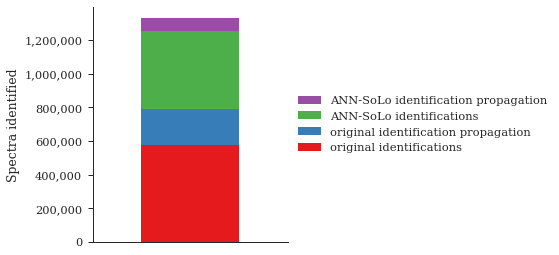

In [27]:
width = 7
height = width / 1.618
fig, ax = plt.subplots(figsize=(width / 2, height))

num_ids = pd.DataFrame([[num_id_massive, num_id_prop_initial,
                         num_id_ann_solo, num_id_prop_ann_solo]],
                       columns=['original identifications',
                                'original identification propagation',
                                'ANN-SoLo identifications',
                                'ANN-SoLo identification propagation'])

num_ids.plot.bar(ax=ax, stacked=True)

ax.set_xticks([])
ax.set_ylabel('Spectra identified')

h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1], loc='center left', bbox_to_anchor=(1, 0.5))

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

sns.despine(ax=ax)

# plt.savefig('id_propagation.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()